# **CNN** *Pytorch*

### **Imports...**

In [9]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

### **GPU/MPS/CPU...**

In [10]:
if torch.cuda.is_available(): 
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"
print(
    f"~~~~~~~~~~~~~~~~~ \n"
    f"Using device: {device} \n"
    f"~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~ 
Using device: mps 
~~~~~~~~~~~~~~~~~


### **CNN...**

In [11]:

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=26): 
       
        super(CNN, self).__init__()

        #1ST CONVOLUTIONAL LAYER
        self.conv1 = nn.Conv2d( 
            in_channels=in_channels,  
            out_channels=64, 
            kernel_size=3, 
            stride=1,  
            padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        
        #2ND CONVOLUTIONAL LAYER
        self.conv2 = nn.Conv2d(  
            in_channels=64,  
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #3RD CONVOLUTIONAL LAYER
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        #POOLING LAYER
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #DROPOUT LAYER (FOR REGULARIZATION)
        self.drop_conv = nn.Dropout2d(p=0.2)
        self.drop_fc = nn.Dropout(p=0.5) 
        
        #FULLY CONNECTED LAYER
        self.adap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.pool(x) 
        x = self.drop_conv(x)          

        x = F.relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = self.drop_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        x = self.adap(x)
        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)       
        x = self.fc2(x)            

        return x
print(
    f"~~~~~~~~~ \n"
    f"CNN ready! \n"
    f"~~~~~~~~~")

~~~~~~~~~ 
CNN ready! 
~~~~~~~~~


### **Hyperparamethers...**

In [12]:
num_classes = 26 
learning_rate = 0.005
batch_size = 128
num_epochs = 100
weight_decay = 0

### **Data loading, preprocessing and transforming...**

In [13]:
def emnist_rotation(img):
    img = img.rotate(-90, expand = True)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def train_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((32,32),antialias=True), 
    transforms.Lambda(emnist_rotation),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

def test_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32),antialias=True),
    transforms.Lambda(emnist_rotation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

train_dataset = datasets.EMNIST(root='emnist-letters-train',split='letters', train=True, download=True, transform=train_transform(), target_transform=lambda y: y-1)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.EMNIST(root='emnist-letters-test', split='letters', train=False, download=True, transform=test_transform(), target_transform=lambda y: y-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### **Initialize network with loss and optimizer...**

In [14]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss(label_smoothing= 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

### **Train and evaluate...**

In [16]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # =======================
    # TRAINING
    # =======================
    model.train()
    train_loss_total = 0.0
    train_correct = 0
    train_samples = 0

    for data, targets in tqdm(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores, targets)

        loss.backward()
        optimizer.step()

        batch_size = targets.size(0)

        # Loss (sum for whole epoch)
        train_loss_total += loss.item() * batch_size

        # Accuracy
        _, preds = scores.max(1)
        train_correct += (preds == targets).sum().item()
        train_samples += batch_size

    train_loss = train_loss_total / train_samples
    train_acc = 100.0 * train_correct / train_samples

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # =======================
    # EVALUATION
    # =======================
    model.eval()
    test_loss_total = 0.0
    test_correct = 0
    test_samples = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = criterion(scores, y)

            batch_size = y.size(0)

            # Loss (sum for whole epoch)
            test_loss_total += loss.item() * batch_size

            # Accuracy
            _, preds = scores.max(1)
            test_correct += (preds == y).sum().item()
            test_samples += batch_size

    test_loss = test_loss_total / test_samples
    test_acc = 100.0 * test_correct / test_samples

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # =======================
    # LOGGING
    # =======================
    print(
        f"TRAIN | acc: {train_acc:.2f}% | loss: {train_loss:.4f}   "
        f"TEST | acc: {test_acc:.2f}% | loss: {test_loss:.4f}"
    )

    # Scheduler step
    scheduler.step()

print("===== Training Complete =====")
print(f"Final Train Acc: {train_accuracies[-1]:.2f}%")
print(f"Final Test Acc: {test_accuracies[-1]:.2f}%")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")


Epoch [1/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:37<00:00, 25.75it/s]


TRAIN | acc: 51.19% | loss: 1.5321   TEST | acc: 86.39% | loss: 0.4454
Epoch [2/100]
Learning rate: 0.004999


100%|██████████| 975/975 [00:40<00:00, 23.82it/s]


TRAIN | acc: 77.42% | loss: 0.7144   TEST | acc: 91.35% | loss: 0.2707
Epoch [3/100]
Learning rate: 0.004995


100%|██████████| 975/975 [00:33<00:00, 29.01it/s]


TRAIN | acc: 82.62% | loss: 0.5535   TEST | acc: 92.14% | loss: 0.2329
Epoch [4/100]
Learning rate: 0.004989


100%|██████████| 975/975 [00:46<00:00, 20.87it/s]


TRAIN | acc: 84.42% | loss: 0.4882   TEST | acc: 92.33% | loss: 0.2216
Epoch [5/100]
Learning rate: 0.004980


100%|██████████| 975/975 [00:33<00:00, 28.82it/s]


TRAIN | acc: 86.09% | loss: 0.4451   TEST | acc: 92.77% | loss: 0.2175
Epoch [6/100]
Learning rate: 0.004969


100%|██████████| 975/975 [00:38<00:00, 25.39it/s]


TRAIN | acc: 86.93% | loss: 0.4183   TEST | acc: 93.43% | loss: 0.1968
Epoch [7/100]
Learning rate: 0.004956


100%|██████████| 975/975 [00:33<00:00, 28.69it/s]


TRAIN | acc: 87.65% | loss: 0.3935   TEST | acc: 93.50% | loss: 0.1918
Epoch [8/100]
Learning rate: 0.004940


100%|██████████| 975/975 [00:40<00:00, 24.35it/s]


TRAIN | acc: 88.18% | loss: 0.3753   TEST | acc: 93.50% | loss: 0.1909
Epoch [9/100]
Learning rate: 0.004921


100%|██████████| 975/975 [00:37<00:00, 26.07it/s]


TRAIN | acc: 88.65% | loss: 0.3593   TEST | acc: 93.62% | loss: 0.1939
Epoch [10/100]
Learning rate: 0.004901


100%|██████████| 975/975 [00:36<00:00, 26.67it/s]


TRAIN | acc: 89.10% | loss: 0.3424   TEST | acc: 94.02% | loss: 0.1863
Epoch [11/100]
Learning rate: 0.004878


100%|██████████| 975/975 [00:36<00:00, 26.60it/s]


TRAIN | acc: 89.49% | loss: 0.3339   TEST | acc: 93.55% | loss: 0.1878
Epoch [12/100]
Learning rate: 0.004852


100%|██████████| 975/975 [00:36<00:00, 26.42it/s]


TRAIN | acc: 89.62% | loss: 0.3272   TEST | acc: 93.59% | loss: 0.1809
Epoch [13/100]
Learning rate: 0.004824


100%|██████████| 975/975 [00:36<00:00, 26.66it/s]


TRAIN | acc: 89.90% | loss: 0.3181   TEST | acc: 94.02% | loss: 0.1810
Epoch [14/100]
Learning rate: 0.004794


100%|██████████| 975/975 [00:36<00:00, 26.55it/s]


TRAIN | acc: 90.23% | loss: 0.3074   TEST | acc: 94.05% | loss: 0.1794
Epoch [15/100]
Learning rate: 0.004762


100%|██████████| 975/975 [00:37<00:00, 26.20it/s]


TRAIN | acc: 90.42% | loss: 0.3036   TEST | acc: 94.16% | loss: 0.1741
Epoch [16/100]
Learning rate: 0.004728


100%|██████████| 975/975 [00:36<00:00, 26.37it/s]


TRAIN | acc: 90.49% | loss: 0.2988   TEST | acc: 94.16% | loss: 0.1712
Epoch [17/100]
Learning rate: 0.004691


100%|██████████| 975/975 [00:36<00:00, 26.38it/s]


TRAIN | acc: 90.68% | loss: 0.2914   TEST | acc: 94.31% | loss: 0.1735
Epoch [18/100]
Learning rate: 0.004652


100%|██████████| 975/975 [00:37<00:00, 26.23it/s]


TRAIN | acc: 90.84% | loss: 0.2891   TEST | acc: 94.57% | loss: 0.1662
Epoch [19/100]
Learning rate: 0.004611


100%|██████████| 975/975 [00:37<00:00, 25.98it/s]


TRAIN | acc: 90.98% | loss: 0.2835   TEST | acc: 94.32% | loss: 0.1722
Epoch [20/100]
Learning rate: 0.004568


100%|██████████| 975/975 [00:37<00:00, 26.24it/s]


TRAIN | acc: 91.06% | loss: 0.2819   TEST | acc: 94.25% | loss: 0.1732
Epoch [21/100]
Learning rate: 0.004523


100%|██████████| 975/975 [00:37<00:00, 26.34it/s]


TRAIN | acc: 91.16% | loss: 0.2783   TEST | acc: 94.14% | loss: 0.1724
Epoch [22/100]
Learning rate: 0.004475


100%|██████████| 975/975 [00:37<00:00, 26.35it/s]


TRAIN | acc: 91.22% | loss: 0.2760   TEST | acc: 94.50% | loss: 0.1706
Epoch [23/100]
Learning rate: 0.004426


100%|██████████| 975/975 [00:37<00:00, 26.30it/s]


TRAIN | acc: 91.22% | loss: 0.2735   TEST | acc: 94.50% | loss: 0.1679
Epoch [24/100]
Learning rate: 0.004375


100%|██████████| 975/975 [00:37<00:00, 26.02it/s]


TRAIN | acc: 91.38% | loss: 0.2683   TEST | acc: 94.56% | loss: 0.1664
Epoch [25/100]
Learning rate: 0.004322


100%|██████████| 975/975 [00:38<00:00, 25.10it/s]


TRAIN | acc: 91.47% | loss: 0.2638   TEST | acc: 94.58% | loss: 0.1691
Epoch [26/100]
Learning rate: 0.004268


100%|██████████| 975/975 [00:38<00:00, 25.03it/s]


TRAIN | acc: 91.50% | loss: 0.2677   TEST | acc: 94.67% | loss: 0.1679
Epoch [27/100]
Learning rate: 0.004211


100%|██████████| 975/975 [00:45<00:00, 21.39it/s]


TRAIN | acc: 91.63% | loss: 0.2613   TEST | acc: 94.69% | loss: 0.1635
Epoch [28/100]
Learning rate: 0.004153


100%|██████████| 975/975 [00:36<00:00, 26.71it/s]


TRAIN | acc: 91.62% | loss: 0.2600   TEST | acc: 94.67% | loss: 0.1640
Epoch [29/100]
Learning rate: 0.004094


100%|██████████| 975/975 [00:36<00:00, 26.79it/s]


TRAIN | acc: 91.78% | loss: 0.2573   TEST | acc: 94.59% | loss: 0.1680
Epoch [30/100]
Learning rate: 0.004032


100%|██████████| 975/975 [00:35<00:00, 27.10it/s]


TRAIN | acc: 91.83% | loss: 0.2552   TEST | acc: 94.73% | loss: 0.1617
Epoch [31/100]
Learning rate: 0.003969


100%|██████████| 975/975 [00:36<00:00, 27.06it/s]


TRAIN | acc: 91.82% | loss: 0.2521   TEST | acc: 94.59% | loss: 0.1706
Epoch [32/100]
Learning rate: 0.003905


100%|██████████| 975/975 [00:35<00:00, 27.24it/s]


TRAIN | acc: 91.97% | loss: 0.2502   TEST | acc: 94.65% | loss: 0.1663
Epoch [33/100]
Learning rate: 0.003840


100%|██████████| 975/975 [00:35<00:00, 27.21it/s]


TRAIN | acc: 91.97% | loss: 0.2528   TEST | acc: 94.83% | loss: 0.1595
Epoch [34/100]
Learning rate: 0.003773


100%|██████████| 975/975 [00:37<00:00, 26.32it/s]


TRAIN | acc: 92.06% | loss: 0.2446   TEST | acc: 94.78% | loss: 0.1624
Epoch [35/100]
Learning rate: 0.003704


100%|██████████| 975/975 [00:35<00:00, 27.20it/s]


TRAIN | acc: 92.02% | loss: 0.2482   TEST | acc: 94.69% | loss: 0.1644
Epoch [36/100]
Learning rate: 0.003635


100%|██████████| 975/975 [00:35<00:00, 27.31it/s]


TRAIN | acc: 92.20% | loss: 0.2420   TEST | acc: 94.68% | loss: 0.1631
Epoch [37/100]
Learning rate: 0.003564


100%|██████████| 975/975 [00:35<00:00, 27.51it/s]


TRAIN | acc: 92.13% | loss: 0.2436   TEST | acc: 94.65% | loss: 0.1581
Epoch [38/100]
Learning rate: 0.003493


100%|██████████| 975/975 [00:35<00:00, 27.48it/s]


TRAIN | acc: 92.29% | loss: 0.2402   TEST | acc: 94.89% | loss: 0.1586
Epoch [39/100]
Learning rate: 0.003420


100%|██████████| 975/975 [00:35<00:00, 27.37it/s]


TRAIN | acc: 92.24% | loss: 0.2374   TEST | acc: 94.70% | loss: 0.1605
Epoch [40/100]
Learning rate: 0.003347


100%|██████████| 975/975 [00:35<00:00, 27.46it/s]


TRAIN | acc: 92.40% | loss: 0.2366   TEST | acc: 94.72% | loss: 0.1601
Epoch [41/100]
Learning rate: 0.003273


100%|██████████| 975/975 [00:35<00:00, 27.52it/s]


TRAIN | acc: 92.36% | loss: 0.2339   TEST | acc: 94.61% | loss: 0.1621
Epoch [42/100]
Learning rate: 0.003197


100%|██████████| 975/975 [00:35<00:00, 27.40it/s]


TRAIN | acc: 92.50% | loss: 0.2301   TEST | acc: 94.76% | loss: 0.1602
Epoch [43/100]
Learning rate: 0.003122


100%|██████████| 975/975 [00:35<00:00, 27.62it/s]


TRAIN | acc: 92.53% | loss: 0.2323   TEST | acc: 94.87% | loss: 0.1621
Epoch [44/100]
Learning rate: 0.003045


100%|██████████| 975/975 [00:35<00:00, 27.21it/s]


TRAIN | acc: 92.66% | loss: 0.2267   TEST | acc: 94.80% | loss: 0.1605
Epoch [45/100]
Learning rate: 0.002968


100%|██████████| 975/975 [00:35<00:00, 27.84it/s]


TRAIN | acc: 92.56% | loss: 0.2301   TEST | acc: 94.76% | loss: 0.1618
Epoch [46/100]
Learning rate: 0.002891


100%|██████████| 975/975 [00:35<00:00, 27.54it/s]


TRAIN | acc: 92.65% | loss: 0.2280   TEST | acc: 94.85% | loss: 0.1611
Epoch [47/100]
Learning rate: 0.002813


100%|██████████| 975/975 [00:35<00:00, 27.65it/s]


TRAIN | acc: 92.75% | loss: 0.2248   TEST | acc: 94.88% | loss: 0.1604
Epoch [48/100]
Learning rate: 0.002735


100%|██████████| 975/975 [00:35<00:00, 27.52it/s]


TRAIN | acc: 92.79% | loss: 0.2195   TEST | acc: 94.77% | loss: 0.1597
Epoch [49/100]
Learning rate: 0.002657


100%|██████████| 975/975 [00:35<00:00, 27.43it/s]


TRAIN | acc: 92.78% | loss: 0.2224   TEST | acc: 94.92% | loss: 0.1604
Epoch [50/100]
Learning rate: 0.002579


100%|██████████| 975/975 [00:35<00:00, 27.54it/s]


TRAIN | acc: 92.81% | loss: 0.2201   TEST | acc: 94.97% | loss: 0.1566
Epoch [51/100]
Learning rate: 0.002500


100%|██████████| 975/975 [00:35<00:00, 27.72it/s]


TRAIN | acc: 92.87% | loss: 0.2204   TEST | acc: 94.97% | loss: 0.1534
Epoch [52/100]
Learning rate: 0.002421


100%|██████████| 975/975 [00:35<00:00, 27.55it/s]


TRAIN | acc: 92.94% | loss: 0.2188   TEST | acc: 94.86% | loss: 0.1555
Epoch [53/100]
Learning rate: 0.002343


100%|██████████| 975/975 [00:35<00:00, 27.51it/s]


TRAIN | acc: 93.00% | loss: 0.2136   TEST | acc: 94.86% | loss: 0.1568
Epoch [54/100]
Learning rate: 0.002265


100%|██████████| 975/975 [00:35<00:00, 27.81it/s]


TRAIN | acc: 92.99% | loss: 0.2178   TEST | acc: 95.01% | loss: 0.1536
Epoch [55/100]
Learning rate: 0.002187


100%|██████████| 975/975 [00:35<00:00, 27.55it/s]


TRAIN | acc: 93.04% | loss: 0.2135   TEST | acc: 94.85% | loss: 0.1548
Epoch [56/100]
Learning rate: 0.002109


100%|██████████| 975/975 [00:35<00:00, 27.61it/s]


TRAIN | acc: 93.04% | loss: 0.2119   TEST | acc: 94.93% | loss: 0.1544
Epoch [57/100]
Learning rate: 0.002032


100%|██████████| 975/975 [00:35<00:00, 27.37it/s]


TRAIN | acc: 93.09% | loss: 0.2126   TEST | acc: 95.13% | loss: 0.1522
Epoch [58/100]
Learning rate: 0.001955


100%|██████████| 975/975 [00:35<00:00, 27.60it/s]


TRAIN | acc: 93.06% | loss: 0.2109   TEST | acc: 95.01% | loss: 0.1594
Epoch [59/100]
Learning rate: 0.001878


100%|██████████| 975/975 [00:35<00:00, 27.52it/s]


TRAIN | acc: 93.10% | loss: 0.2104   TEST | acc: 95.11% | loss: 0.1538
Epoch [60/100]
Learning rate: 0.001803


100%|██████████| 975/975 [00:35<00:00, 27.65it/s]


TRAIN | acc: 93.15% | loss: 0.2088   TEST | acc: 95.01% | loss: 0.1520
Epoch [61/100]
Learning rate: 0.001727


100%|██████████| 975/975 [00:35<00:00, 27.27it/s]


TRAIN | acc: 93.26% | loss: 0.2052   TEST | acc: 94.88% | loss: 0.1554
Epoch [62/100]
Learning rate: 0.001653


100%|██████████| 975/975 [00:35<00:00, 27.74it/s]


TRAIN | acc: 93.21% | loss: 0.2055   TEST | acc: 95.08% | loss: 0.1546
Epoch [63/100]
Learning rate: 0.001580


100%|██████████| 975/975 [00:35<00:00, 27.45it/s]


TRAIN | acc: 93.20% | loss: 0.2067   TEST | acc: 95.08% | loss: 0.1547
Epoch [64/100]
Learning rate: 0.001507


100%|██████████| 975/975 [00:42<00:00, 23.09it/s]


TRAIN | acc: 93.31% | loss: 0.2048   TEST | acc: 94.94% | loss: 0.1531
Epoch [65/100]
Learning rate: 0.001436


100%|██████████| 975/975 [00:43<00:00, 22.19it/s]


TRAIN | acc: 93.39% | loss: 0.2005   TEST | acc: 95.03% | loss: 0.1526
Epoch [66/100]
Learning rate: 0.001365


100%|██████████| 975/975 [00:46<00:00, 21.14it/s]


TRAIN | acc: 93.37% | loss: 0.2021   TEST | acc: 95.05% | loss: 0.1541
Epoch [67/100]
Learning rate: 0.001296


100%|██████████| 975/975 [00:41<00:00, 23.75it/s]


TRAIN | acc: 93.36% | loss: 0.2032   TEST | acc: 95.08% | loss: 0.1521
Epoch [68/100]
Learning rate: 0.001227


100%|██████████| 975/975 [00:45<00:00, 21.38it/s]


TRAIN | acc: 93.50% | loss: 0.1999   TEST | acc: 95.10% | loss: 0.1521
Epoch [69/100]
Learning rate: 0.001160


100%|██████████| 975/975 [00:37<00:00, 25.74it/s]


TRAIN | acc: 93.46% | loss: 0.1979   TEST | acc: 95.14% | loss: 0.1515
Epoch [70/100]
Learning rate: 0.001095


100%|██████████| 975/975 [00:37<00:00, 26.09it/s]


TRAIN | acc: 93.43% | loss: 0.1987   TEST | acc: 95.04% | loss: 0.1521
Epoch [71/100]
Learning rate: 0.001031


100%|██████████| 975/975 [00:37<00:00, 26.16it/s]


TRAIN | acc: 93.58% | loss: 0.1958   TEST | acc: 95.18% | loss: 0.1495
Epoch [72/100]
Learning rate: 0.000968


100%|██████████| 975/975 [00:36<00:00, 26.46it/s]


TRAIN | acc: 93.47% | loss: 0.1988   TEST | acc: 95.03% | loss: 0.1490
Epoch [73/100]
Learning rate: 0.000906


100%|██████████| 975/975 [00:36<00:00, 26.61it/s]


TRAIN | acc: 93.57% | loss: 0.1959   TEST | acc: 95.10% | loss: 0.1501
Epoch [74/100]
Learning rate: 0.000847


100%|██████████| 975/975 [00:36<00:00, 26.77it/s]


TRAIN | acc: 93.52% | loss: 0.1963   TEST | acc: 95.07% | loss: 0.1500
Epoch [75/100]
Learning rate: 0.000789


100%|██████████| 975/975 [00:36<00:00, 26.45it/s]


TRAIN | acc: 93.59% | loss: 0.1933   TEST | acc: 95.04% | loss: 0.1514
Epoch [76/100]
Learning rate: 0.000732


100%|██████████| 975/975 [00:37<00:00, 25.99it/s]


TRAIN | acc: 93.63% | loss: 0.1925   TEST | acc: 95.01% | loss: 0.1512
Epoch [77/100]
Learning rate: 0.000678


100%|██████████| 975/975 [00:38<00:00, 25.04it/s]


TRAIN | acc: 93.60% | loss: 0.1922   TEST | acc: 95.13% | loss: 0.1499
Epoch [78/100]
Learning rate: 0.000625


100%|██████████| 975/975 [00:38<00:00, 25.60it/s]


TRAIN | acc: 93.64% | loss: 0.1918   TEST | acc: 95.05% | loss: 0.1514
Epoch [79/100]
Learning rate: 0.000574


100%|██████████| 975/975 [00:37<00:00, 26.10it/s]


TRAIN | acc: 93.61% | loss: 0.1913   TEST | acc: 95.07% | loss: 0.1501
Epoch [80/100]
Learning rate: 0.000525


100%|██████████| 975/975 [00:37<00:00, 26.18it/s]


TRAIN | acc: 93.67% | loss: 0.1908   TEST | acc: 95.16% | loss: 0.1498
Epoch [81/100]
Learning rate: 0.000477


100%|██████████| 975/975 [00:36<00:00, 26.38it/s]


TRAIN | acc: 93.64% | loss: 0.1879   TEST | acc: 95.03% | loss: 0.1516
Epoch [82/100]
Learning rate: 0.000432


100%|██████████| 975/975 [00:37<00:00, 25.97it/s]


TRAIN | acc: 93.71% | loss: 0.1903   TEST | acc: 95.16% | loss: 0.1484
Epoch [83/100]
Learning rate: 0.000389


100%|██████████| 975/975 [00:36<00:00, 26.42it/s]


TRAIN | acc: 93.69% | loss: 0.1899   TEST | acc: 95.23% | loss: 0.1494
Epoch [84/100]
Learning rate: 0.000348


100%|██████████| 975/975 [00:36<00:00, 26.44it/s]


TRAIN | acc: 93.76% | loss: 0.1870   TEST | acc: 95.17% | loss: 0.1494
Epoch [85/100]
Learning rate: 0.000309


100%|██████████| 975/975 [00:37<00:00, 26.23it/s]


TRAIN | acc: 93.72% | loss: 0.1891   TEST | acc: 95.14% | loss: 0.1485
Epoch [86/100]
Learning rate: 0.000272


100%|██████████| 975/975 [00:38<00:00, 25.44it/s]


TRAIN | acc: 93.81% | loss: 0.1889   TEST | acc: 95.12% | loss: 0.1494
Epoch [87/100]
Learning rate: 0.000238


100%|██████████| 975/975 [00:37<00:00, 26.02it/s]


TRAIN | acc: 93.77% | loss: 0.1872   TEST | acc: 95.15% | loss: 0.1490
Epoch [88/100]
Learning rate: 0.000206


100%|██████████| 975/975 [00:37<00:00, 26.01it/s]


TRAIN | acc: 93.77% | loss: 0.1874   TEST | acc: 95.17% | loss: 0.1490
Epoch [89/100]
Learning rate: 0.000176


100%|██████████| 975/975 [00:37<00:00, 26.01it/s]


TRAIN | acc: 93.80% | loss: 0.1863   TEST | acc: 95.17% | loss: 0.1495
Epoch [90/100]
Learning rate: 0.000148


100%|██████████| 975/975 [00:37<00:00, 26.08it/s]


TRAIN | acc: 93.84% | loss: 0.1860   TEST | acc: 95.16% | loss: 0.1490
Epoch [91/100]
Learning rate: 0.000122


100%|██████████| 975/975 [00:37<00:00, 25.98it/s]


TRAIN | acc: 93.84% | loss: 0.1862   TEST | acc: 95.19% | loss: 0.1487
Epoch [92/100]
Learning rate: 0.000099


100%|██████████| 975/975 [00:36<00:00, 26.51it/s]


TRAIN | acc: 93.84% | loss: 0.1865   TEST | acc: 95.16% | loss: 0.1492
Epoch [93/100]
Learning rate: 0.000079


100%|██████████| 975/975 [00:33<00:00, 28.72it/s]


TRAIN | acc: 93.82% | loss: 0.1856   TEST | acc: 95.18% | loss: 0.1490
Epoch [94/100]
Learning rate: 0.000060


100%|██████████| 975/975 [00:34<00:00, 28.66it/s]


TRAIN | acc: 93.79% | loss: 0.1866   TEST | acc: 95.18% | loss: 0.1487
Epoch [95/100]
Learning rate: 0.000044


100%|██████████| 975/975 [00:33<00:00, 28.95it/s]


TRAIN | acc: 93.85% | loss: 0.1846   TEST | acc: 95.19% | loss: 0.1493
Epoch [96/100]
Learning rate: 0.000031


100%|██████████| 975/975 [00:33<00:00, 29.03it/s]


TRAIN | acc: 93.83% | loss: 0.1854   TEST | acc: 95.17% | loss: 0.1488
Epoch [97/100]
Learning rate: 0.000020


100%|██████████| 975/975 [00:37<00:00, 25.97it/s]


TRAIN | acc: 93.90% | loss: 0.1855   TEST | acc: 95.18% | loss: 0.1487
Epoch [98/100]
Learning rate: 0.000011


100%|██████████| 975/975 [00:38<00:00, 25.31it/s]


TRAIN | acc: 93.88% | loss: 0.1846   TEST | acc: 95.16% | loss: 0.1492
Epoch [99/100]
Learning rate: 0.000005


100%|██████████| 975/975 [00:38<00:00, 25.29it/s]


TRAIN | acc: 93.77% | loss: 0.1884   TEST | acc: 95.20% | loss: 0.1487
Epoch [100/100]
Learning rate: 0.000001


100%|██████████| 975/975 [00:40<00:00, 23.94it/s]


TRAIN | acc: 93.83% | loss: 0.1864   TEST | acc: 95.17% | loss: 0.1488
===== Training Complete =====
Final Train Acc: 93.83%
Final Test Acc: 95.17%
Final Train Loss: 0.1864
Final Test Loss: 0.1488


### **Plotting...**

In [21]:
def plot_stats(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc)+1)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    best_epoch = test_acc.index(max(test_acc))
    best_acc = test_acc[best_epoch]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ACCURACY PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1.plot(epochs, train_acc, label="Train Accuracy", color='salmon')
    ax1.plot(epochs, test_acc, label="Test Accuracy", color='sienna')

    ax1.scatter(best_epoch + 1, best_acc, color='indianred', s=50, zorder=5, label=f"Best Test acc ({best_acc:.2f}%) at epoch {best_epoch}")
    ax1.annotate(f'{best_acc:.2f}%',
                 xy=(best_epoch + 1, best_acc),
                 xytext=(best_epoch + 1, best_acc - 6),
                 ha='center', color='indianred',
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax1.set_title('Train vs. test accuracy')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)", color='Sienna')
    ax1.tick_params(axis='y', labelcolor='Sienna')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOSS PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax2.plot(epochs, train_loss, label="Train Loss", color='salmon')
    ax2.plot(epochs, test_loss, label="Test Loss", color='sienna')
    ax2.set_title('Train vs. test loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss", color='sienna')
    ax2.tick_params(axis='y', labelcolor='sienna')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.savefig("CNN_results_plot.png")
    plt.tight_layout()
    plt.show()

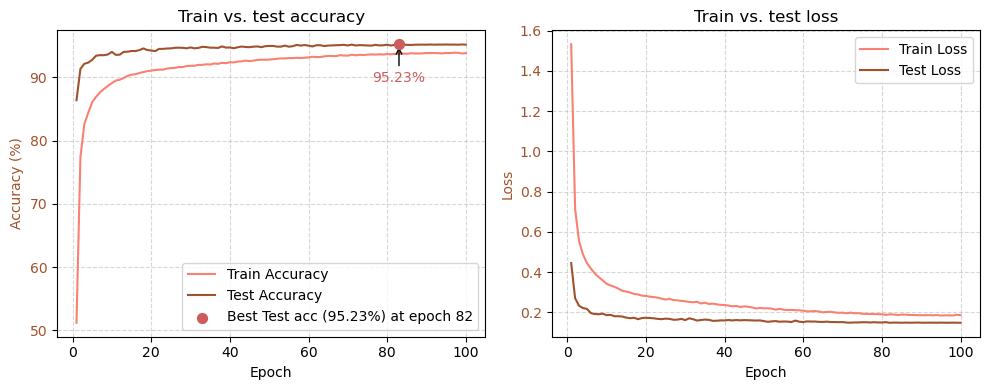

In [22]:
plot_stats(
    train_accuracies, 
    test_accuracies, 
    train_losses, 
    test_losses
)

### **Save results in file...**

In [23]:
filename = "CNN_results_decreasing_lr.txt"  

with open(filename, "w") as f:
    f.write("Epoch, Train loss, Train acc, Test loss, Test acc\n")
    
    for i in range(num_epochs):
        f.write(
            f"{i+1}, "
            f"{train_losses[i]:.4f}, "
            f"{train_accuracies[i]:.2f}%, " 
            f"{test_losses[i]:.4f}, "
            f"{test_accuracies[i]:.2f}%\n")

    f.write("\n" + "="*40 + "\n")
    f.write("Final Metrics\n")
    f.write(f"Final Train Loss:     {train_losses[-1]:.4f}\n")
    f.write(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%\n")
    f.write(f"Final Test Loss:      {test_losses[-1]:.4f}\n")
    f.write(f"Final Test Accuracy:  {test_accuracies[-1]:.2f}%\n")
    f.write("="*40 + "\n")

print(f"Resultater gemt i: {filename}")

Resultater gemt i: CNN_results_decreasing_lr.txt


### **Gem efter træning:**

In [24]:
torch.save(model.state_dict(), "my_model_state_dict.pth")